In [194]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.mixed_linear_model import MixedLM
import pingouin as pg

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice
plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
figdir = "C://Users/esay/data/Stx3/YMazeResults/neural/reward_overrep"
os.makedirs(figdir, exist_ok = True)

In [196]:
df = pd.DataFrame({'mouse':[],
                                'ko':[],
                                'day':[], 
                                'lr':[], 
                                'novfam':[], 
                                'frac': [], 
                                })



In [197]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice

In [198]:
sparse_mice[3:]

('SparseKO_06',
 'SparseKO_08',
 'SparseKO_09',
 'SparseKO_10',
 'SparseKO_11',
 'SparseKO_13')

In [247]:
class LMM_PeriRewardPlaceCellFrac:

    def __init__(self, days = np.arange(6), ts_key = 'spks'):

        '''


        :param days:
        :param ts_key:
        '''
        
        self.ko_mice = stx.ymaze_sess_deets.ko_mice
        self.ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
        self.sparse_mice =stx.ymaze_sess_deets.sparse_mice[3:]
        self.__dict__.update({'days': days, 'ts_key': ts_key})
        self.n_days = days.shape[0]

        self.df = pd.DataFrame({'mouse':[],
                                'ko':[],
                                'day':[], 
                                'lr':[], 
                                'novfam':[], 
                                'frac': [], 
                                })
        self.fill_df()
        

    def fill_df(self):
        # for m, mouse in enumerate(self.ctrl_mice):
        #     for day in self.days:
        #         self.argmax_perireward(u.load_single_day(mouse,day),m,0,day)
                
        # for m, mouse in enumerate(self.ko_mice):
        #     for day in self.days:
        #         self.argmax_perireward(u.load_single_day(mouse, day),m+len(self.ctrl_mice), 1,day)
                
        for m, mouse in enumerate(self.sparse_mice):
            if mouse == 'SparseKO_12':
                self.days = np.arange(2)
            elif mouse == 'SparseKO_09':
                self.days = np.arange(5)
            else:
                self.days = np.arange(6)
            for day in self.days:
                self.argmax_perireward_ES(u.load_single_day(mouse, day),m+len(self.sparse_mice), 1,day, is_sparse=True) 
        
                
                
                

    def argmax_perireward(self, sess, m, ko, day, ts_key: str = 'spks'):
        '''

        :param sess:
        :param ts_key:
        :param fam:
        :return:
        '''
        
        trials_mat = sess.trial_matrices[ts_key]
        bin_edges = sess.trial_matrices['bin_edges']

        
        for _arm, arm in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']==arm
            if sess.novel_arm == arm:
                cell_mask = sess.nov_place_cell_mask()
                rzone_front = np.argwhere((sess.rzone_nov['tfront'] <= bin_edges[1:]) * \
                                          (sess.rzone_nov['tfront'] >= bin_edges[:-1]))[0][0]
                nov = 'nov'
            else:
                cell_mask = sess.fam_place_cell_mask()
                rzone_front = np.argwhere((sess.rzone_fam['tfront'] <= bin_edges[1:]) * \
                                          (sess.rzone_fam['tfront'] >= bin_edges[:-1]))[0][0]
                nov = 'fam'



            # smooth ratemap by 1 bin
            ratemap = sp.ndimage.gaussian_filter1d(np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0)
            max_inds = np.argmax(ratemap[:,cell_mask], axis = 0) - rzone_front
            reward_frac = self.get_frac(max_inds)
            
            self.df = pd.concat((self.df, pd.DataFrame({'mouse': sess.mouse, 
                                     'ko': ko, 
                                     'day': day,
                                     'lr': _arm, 
                                     'novfam': nov, 
                                     'frac': reward_frac,},
                                    index=[len(self.df)])), ignore_index=True)
            
        
    def argmax_perireward_ES(self, sess, m, ko, day, ts_key: str = 'F_dff_speed_filt', is_sparse=False):
        '''
        :param sess: session object
        :param m: mouse index
        :param ko: knockout indicator
        :param day: experimental day
        :param ts_key: time series key
        :param is_sparse: flag indicating if sparse_mice is being processed
        '''
                    
        # if mouse in self.sparse_mice:
            
        for chan in ['channel_0', 'channel_1']:

                
            trials_mat = sess.trial_matrices[f"{chan}_{ts_key}"]
            bin_edges = sess.trial_matrices['bin_edges']
            for _arm, arm in enumerate([-1, 1]):
                trial_mask = sess.trial_info['LR'] == arm
                if sess.novel_arm == arm:

                    cell_mask = sess.nov_place_cell_mask(mux = True, chan = chan)
                    rzone_front = np.argwhere(
                        (sess.rzone_nov['tfront'] <= bin_edges[1:]) &
                        (sess.rzone_nov['tfront'] >= bin_edges[:-1])
                    )[0][0]
                    nov = 'nov'
                else:
                        
                    cell_mask = sess.fam_place_cell_mask(mux= True, chan=chan)
                    rzone_front = np.argwhere(
                        (sess.rzone_fam['tfront'] <= bin_edges[1:]) &
                        (sess.rzone_fam['tfront'] >= bin_edges[:-1])
                    )[0][0]
                    nov = 'fam'
                # Smooth ratemap by 1 bin
                ratemap = sp.ndimage.gaussian_filter1d(
                    np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0
                )
                max_inds = np.argmax(ratemap[:, cell_mask], axis=0) - rzone_front
                reward_frac = self.get_frac(max_inds)
                # Add to dataframe
                self.df = pd.concat((
                    self.df,
                    pd.DataFrame({
                        'mouse': sess.mouse,
                        'ko': ko,
                        'day': day,
                        'lr': _arm,
                        'novfam': nov,
                        'channel': chan,  # Add channel info to the dataframe
                        'frac': reward_frac
                    }, index=[len(self.df)])
                ), ignore_index=True)

    
    @staticmethod
    def get_frac(data):
        '''

        :param frac:
        :return:
        '''
        x = np.arange(-30, 15)
        anova_mask = (x >= -5) * (x <= -1)

        hist = np.array([np.count_nonzero(data.ravel() == _bin) for _bin in x.tolist()])
        hist = hist / hist.sum()
        # return hist[anova_mask].sum() / hist[~anova_mask].sum()
        return hist[anova_mask].sum() / hist.sum()

    

In [256]:
mouse = 'SparseKO_06'
day = 0
sess = u.load_single_day(mouse, day)

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


In [252]:
lmm_frac = LMM_PeriRewardPlaceCellFrac()

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'sc

In [254]:
np.where(lmm_frac.df['mouse']=='SparseKO_09')
sparseKO_09 = lmm_frac.df.iloc[48:68]
sparseKO_09

# lmm_frac.df.drop(lmm_frac.df.index[48:68],inplace=True)

# lmm_frac.df[60:68] = lmm_frac.df['day'][60:68] + 1

,mouse,ko,day,lr,novfam,frac,channel
68,SparseKO_10,1.0,0.0,0.0,fam,0.113402,channel_0
69,SparseKO_10,1.0,0.0,1.0,nov,0.125000,channel_0
70,SparseKO_10,1.0,0.0,0.0,fam,0.234043,channel_1
71,SparseKO_10,1.0,0.0,1.0,nov,0.333333,channel_1
72,SparseKO_10,1.0,1.0,0.0,fam,0.129213,channel_0
73,SparseKO_10,1.0,1.0,1.0,nov,0.240964,channel_0
74,SparseKO_10,1.0,1.0,0.0,fam,0.200000,channel_1
75,SparseKO_10,1.0,1.0,1.0,nov,0.183673,channel_1
76,SparseKO_10,1.0,2.0,0.0,fam,0.142857,channel_0
77,SparseKO_10,1.0,2.0,1.0,nov,0.139241,channel_0


In [223]:
lmm_frac.df.to_pickle("C:/Users/esay/data/Stx3/YMazeSessPkls/df_rewardfrac_spks.pkl")

In [245]:
lmm_frac.df

,mouse,ko,day,lr,novfam,frac,channel
0,SparseKO_06,1.0,0.0,0.0,fam,0.213483,channel_0
1,SparseKO_06,1.0,0.0,1.0,nov,0.146067,channel_0
2,SparseKO_06,1.0,0.0,0.0,fam,0.276596,channel_1
3,SparseKO_06,1.0,0.0,1.0,nov,0.040000,channel_1
4,SparseKO_06,1.0,1.0,0.0,fam,0.256983,channel_0
...,...,...,...,...,...,...,...
135,SparseKO_13,1.0,4.0,1.0,nov,0.275862,channel_1
136,SparseKO_13,1.0,5.0,0.0,fam,0.429907,channel_0
137,SparseKO_13,1.0,5.0,1.0,nov,0.130952,channel_0
138,SparseKO_13,1.0,5.0,0.0,fam,0.314286,channel_1


In [129]:
# change names to run statistical testing (DO NOT RUN)
for i in range(len(lmm_frac.df)):
    if lmm_frac.df['channel'][i] == 'channel_0':
        lmm_frac.df['chan'][i] = 0
        lmm_frac.df['mouse'][i] = lmm_frac.df['mouse'][i][: -2 ]
    else:
        lmm_frac.df['chan'][i] = 1
        lmm_frac.df['mouse'][i] = lmm_frac.df['mouse'][i][: - 2]

    

C:\Users\esay\AppData\Local\Temp\ipykernel_104912\243814262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lmm_frac.df['chan'][i] = 0
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\243814262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lmm_frac.df['mouse'][i] = lmm_frac.df['mouse'][i][: -2 ]
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\243814262.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lmm_frac.df['chan']

In [125]:
res = pg.mixed_anova(data = lmm_frac.df[lmm_frac.df['novfam']=='nov'], dv= 'frac', between = 'chan', within = 'day', subject = 'mouse')
print(res)

posthoc = pg.pairwise_tests(data = lmm_frac.df[lmm_frac.df['novfam']=='nov'], dv= 'frac', between = 'chan', within = 'day', subject = 'mouse', padjust='holm',parametric = False)
print(posthoc)



        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0         chan  0.150568    1    8  0.150568  15.658905  0.004194  0.661861   
1          day  0.064895    5   40  0.012979   3.289388  0.013974  0.291370   
2  Interaction  0.022570    5   40  0.004514   1.143998  0.353397  0.125109   

        eps  
0       NaN  
1  0.561267  
2       NaN  
      Contrast  day    A    B Paired  Parametric  U-val  W-val alternative  \
0          day    -  0.0  1.0   True       False    NaN   24.0   two-sided   
1          day    -  0.0  2.0   True       False    NaN    9.0   two-sided   
2          day    -  0.0  3.0   True       False    NaN   10.0   two-sided   
3          day    -  0.0  4.0   True       False    NaN   11.0   two-sided   
4          day    -  0.0  5.0   True       False    NaN   23.0   two-sided   
5          day    -  1.0  2.0   True       False    NaN   10.0   two-sided   
6          day    -  1.0  3.0   True       False    NaN   10.0   two-sided   
7  

In [126]:
res = pg.mixed_anova(data = lmm_frac.df[lmm_frac.df['novfam']=='fam'], dv= 'frac', between = 'chan', within = 'day', subject = 'mouse')
print(res)

posthoc = pg.pairwise_ttests(data = lmm_frac.df[lmm_frac.df['novfam']=='fam'], dv= 'frac', between = 'chan', within = 'day', subject = 'mouse', padjust='holm',parametric = False)
print(posthoc)



        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0         chan  0.147127    1    8  0.147127  9.232948  0.016098  0.535773   
1          day  0.047725    5   40  0.009545  1.936364  0.109661  0.194877   
2  Interaction  0.042462    5   40  0.008492  1.722807  0.151613  0.177192   

        eps  
0       NaN  
1  0.537202  
2       NaN  
      Contrast  day    A    B Paired  Parametric  U-val  W-val alternative  \
0          day    -  0.0  1.0   True       False    NaN   15.0   two-sided   
1          day    -  0.0  2.0   True       False    NaN   14.0   two-sided   
2          day    -  0.0  3.0   True       False    NaN   20.0   two-sided   
3          day    -  0.0  4.0   True       False    NaN   18.0   two-sided   
4          day    -  0.0  5.0   True       False    NaN   27.0   two-sided   
5          day    -  1.0  2.0   True       False    NaN   19.0   two-sided   
6          day    -  1.0  3.0   True       False    NaN   25.0   two-sided   
7      

C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


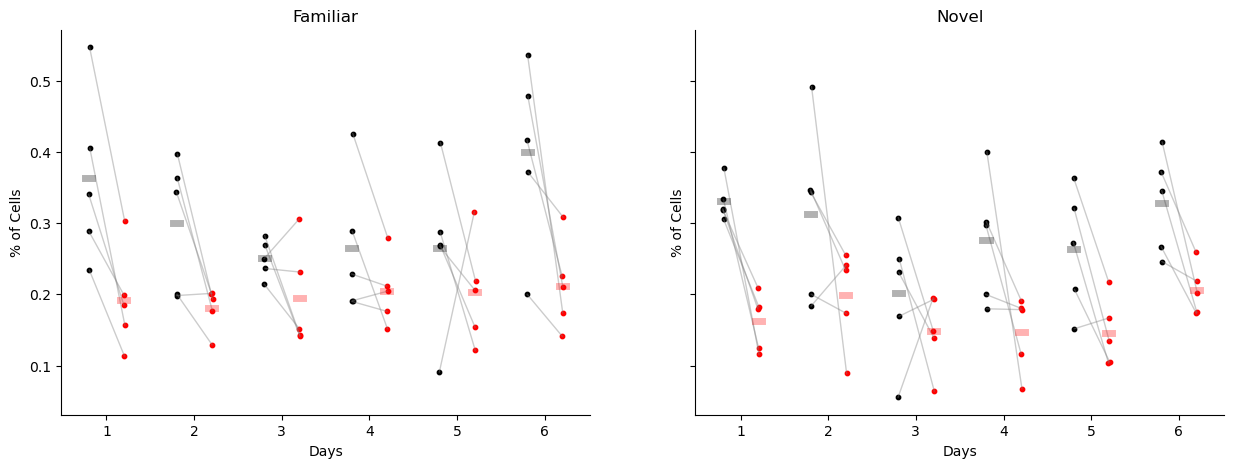

In [255]:
fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
s = 10
lw = 5

for day in range(6):
    for novfam, axis_idx in zip(['fam', 'nov'], [0, 1]):
        frac_ch1 = []
        frac_ch0 = []
        xvals_ch1 = []
        xvals_ch0 = []

        for i, mouse in enumerate(sparse_mice):
            mask_ch1 = (
                (lmm_frac.df['channel'] == 'channel_1') &
                (lmm_frac.df['day'] == day) &
                (lmm_frac.df['novfam'] == novfam) &
                (lmm_frac.df['mouse'] == mouse)
            )
            mask_ch0 = (
                (lmm_frac.df['channel'] == 'channel_0') &
                (lmm_frac.df['day'] == day) &
                (lmm_frac.df['novfam'] == novfam) &
                (lmm_frac.df['mouse'] == mouse)
            )

            vals_ch1 = lmm_frac.df['frac'].loc[mask_ch1]._values
            vals_ch0 = lmm_frac.df['frac'].loc[mask_ch0]._values

            x1 = 5 * day - 1 if novfam == 'fam' else 5 * day - 1
            x0 = 5 * day + 1 if novfam == 'fam' else 5 * day + 1
            offset = np.linspace(-0.05, 0.05, num=len(sparse_mice))[i]

            if len(vals_ch1):
                frac = vals_ch1.mean()
                frac_ch1.append(frac)
                xvals_ch1.append(x1 + offset)
                ax[axis_idx].scatter(x1 + offset, frac, color='black', s=s)

            if len(vals_ch0):
                frac = vals_ch0.mean()
                frac_ch0.append(frac)
                xvals_ch0.append(x0 + offset)
                ax[axis_idx].scatter(x0 + offset, frac, color='red', s=s)

            # Draw line between ch1 and ch0 points for this mouse if both exist
            if len(vals_ch1) and len(vals_ch0):
                ax[axis_idx].plot(
                    [x1 + offset, x0 + offset],
                    [vals_ch1.mean(), vals_ch0.mean()],
                    color='gray', alpha=0.4, linewidth=1
                )

        # Plot group mean bars
        if frac_ch1:
            ax[axis_idx].plot(
                x1 + np.array([-0.2, 0.2]),
                [np.mean(frac_ch1)] * 2,
                color='black', linewidth=lw, alpha=0.3
            )
        if frac_ch0:
            ax[axis_idx].plot(
                x0 + np.array([-0.2, 0.2]),
                [np.mean(frac_ch0)] * 2,
                color='red', linewidth=lw, alpha=0.3
            )

ax[0].set_title('Familiar')
ax[1].set_title('Novel')

for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("% of Cells")
    ax[a].set_xticks(5 * np.arange(6))
    ax[a].set_xticklabels(np.arange(1, 7))


C:\Users\esay\AppData\Local\Temp\ipykernel_104912\965801399.py:6: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\965801399.py:11: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\965801399.py:16: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\965801399.py:21: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df['fra

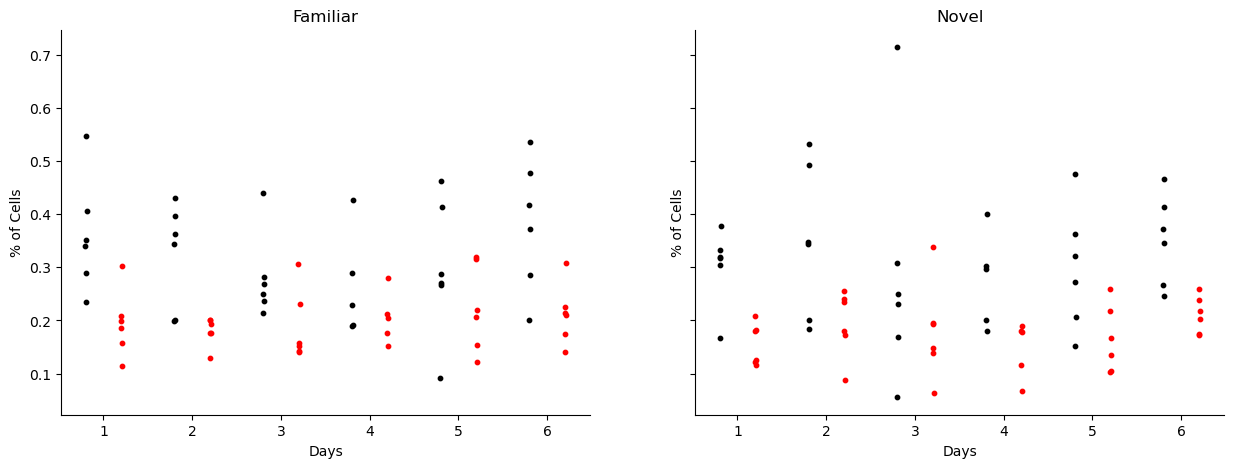

In [210]:
fig, ax = plt.subplots(1,2,figsize = [15,5], sharey=True)
s = 10
lw = 5
for day in range(6):
    mask = (lmm_frac.df['channel']=='channel_1') & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='fam')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[0].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'black', s=s)
    ax[0].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['channel']=='channel_1') & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='nov')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[1].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'black', s=s, alpha = 1)
    ax[1].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['channel']=='channel_0') & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='fam')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[0].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'red', s=s)
    ax[0].plot(5*day  +1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth =lw, alpha = .3)
    
    mask = (lmm_frac.df['channel']=='channel_0') & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='nov')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[1].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'red', s=s, alpha = 1)
    ax[1].plot(5*day +1+ np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    
    ax[0].set_title('Familiar')
    ax[1].set_title('Novel')

    
# ax[0].plot([-2.3, 27.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
# ax[1].plot([-2.3, 27.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("% of Cells")
    ax[a].set_xticks(5*np.arange(6))
    ax[a].set_xticklabels(np.arange(1,7))
# fig.savefig(os.path.join(figdir, 'reward_frac_summary.pdf'))

C:\Users\esay\AppData\Local\Temp\ipykernel_104912\1954521583.py:6: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\1954521583.py:12: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\1954521583.py:17: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\1954521583.py:22: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df[

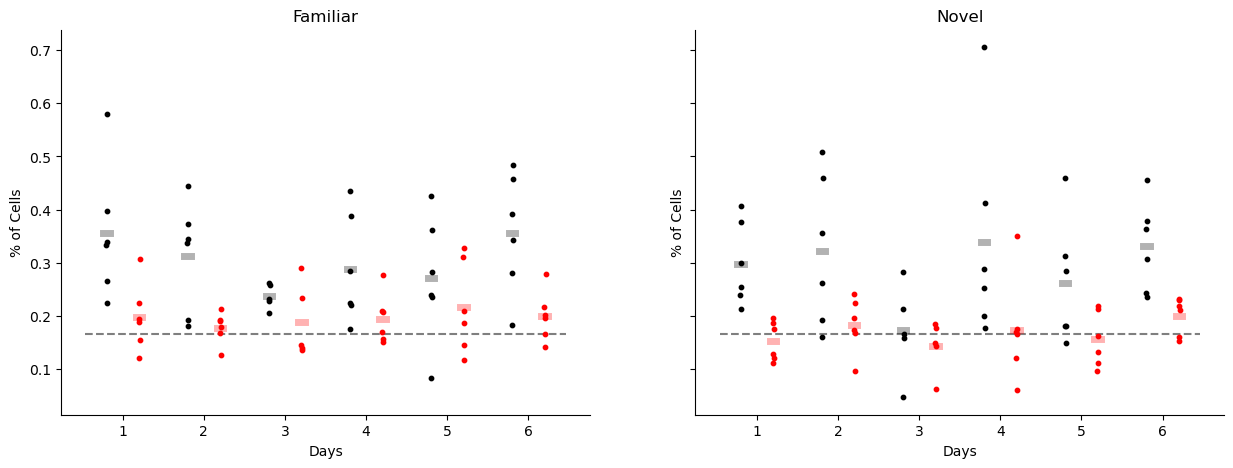

In [192]:
fig, ax = plt.subplots(1,2,figsize = [15,5], sharey=True)
s = 10
lw = 5
for day in range(6):
    mask = (lmm_frac.df['chan']==1) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='fam')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[0].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'black', s=s)
    
    ax[0].plot(5*day  -1 + np.array([-0.2,0.2]), np.nanmean(frac)*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['chan']==1) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='nov')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[1].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'black', s=s, alpha = 1)
    ax[1].plot(5*day  -1 + np.array([-0.2,0.2]), np.nanmean(frac)*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['chan']==0) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='fam')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[0].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'red', s=s)
    ax[0].plot(5*day  +1 + np.array([-0.2,0.2]), np.nanmean(frac)*np.ones([2,]), color='red', linewidth =lw, alpha = .3)
    
    mask = (lmm_frac.df['chan']==0) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='nov')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[1].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'red', s=s, alpha = 1)
    ax[1].plot(5*day +1+ np.array([-0.2,0.2]), np.nanmean(frac)*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    
    ax[0].set_title('Familiar')
    ax[1].set_title('Novel')

    '''
     Dashed line indicates the proportion of reward coding neurons expected by random remapping between novel and familiar arms with constant coding for the stem of the maze. 
     '''
    
ax[0].plot([-2.3, 27.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
ax[1].plot([-2.3, 27.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("% of Cells")
    ax[a].set_xticks(5*np.arange(6))
    ax[a].set_xticklabels(np.arange(1,7))
# fig.savefig(os.path.join(figdir, 'reward_frac_summary.pdf'))

In [146]:
ctrl_frac, ko_frac

(array([0.13257576, 0.27711591, 0.36842105, 0.2612782 , 0.21633987,
        0.27176015]),
 array([0.20478049, 0.20049261, 0.21388593, 0.13839783, 0.140484  ,
        0.16010101]))

0.0 0.03125


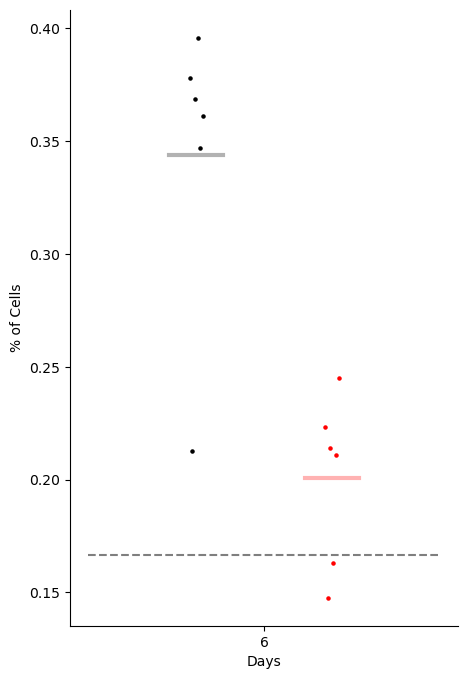

In [193]:
fig, ax = plt.subplots(figsize=[5,8])

# somehow fix so this can plot day 6 for all mice (9 is currently missing one day)
for day in [5]: #range(5,6):
    mask = (lmm_frac.df['chan']==1) & (lmm_frac.df['day']==day) #& (lmm_frac.df['novfam']==0)
    ctrl_frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice[3:]])
    ax.scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(sparse_mice[3:])), ctrl_frac, color = 'black', s=5)
    ax.plot(5*day  -.5 + np.array([-0.2,0.2]), ctrl_frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    
    mask = (lmm_frac.df['chan']==0) & (lmm_frac.df['day']==day) #& (lmm_frac.df['novfam']==0)
    ko_frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice[3:]])
    ax.scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(sparse_mice[3:])), ko_frac, color = 'red', s=5)
    ax.plot(5*day  +.5 + np.array([-0.2,0.2]), ko_frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("% of Cells")
ax.set_xticks(5*np.arange(5,6))
ax.set_xticklabels(np.arange(6,7))

ax.plot([23.7, 26.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
    
t,p = sp.stats.ranksums(ctrl_frac,ko_frac)
t,p = sp.stats.wilcoxon(ko_frac-4/30)
print(t,p)
# fig.savefig(os.path.join(figdir, "reward_pc_frac_summary_short.pdf"))

In [55]:
sess.place_cell_info.keys()

dict_keys(['channel_0_F_dff', 'channel_1_F_dff'])

In [85]:
fam_pc_fracs = stx.reward_overrep.PeriRewardPlaceCellFrac(fam=True, days = np.arange(5))

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 's

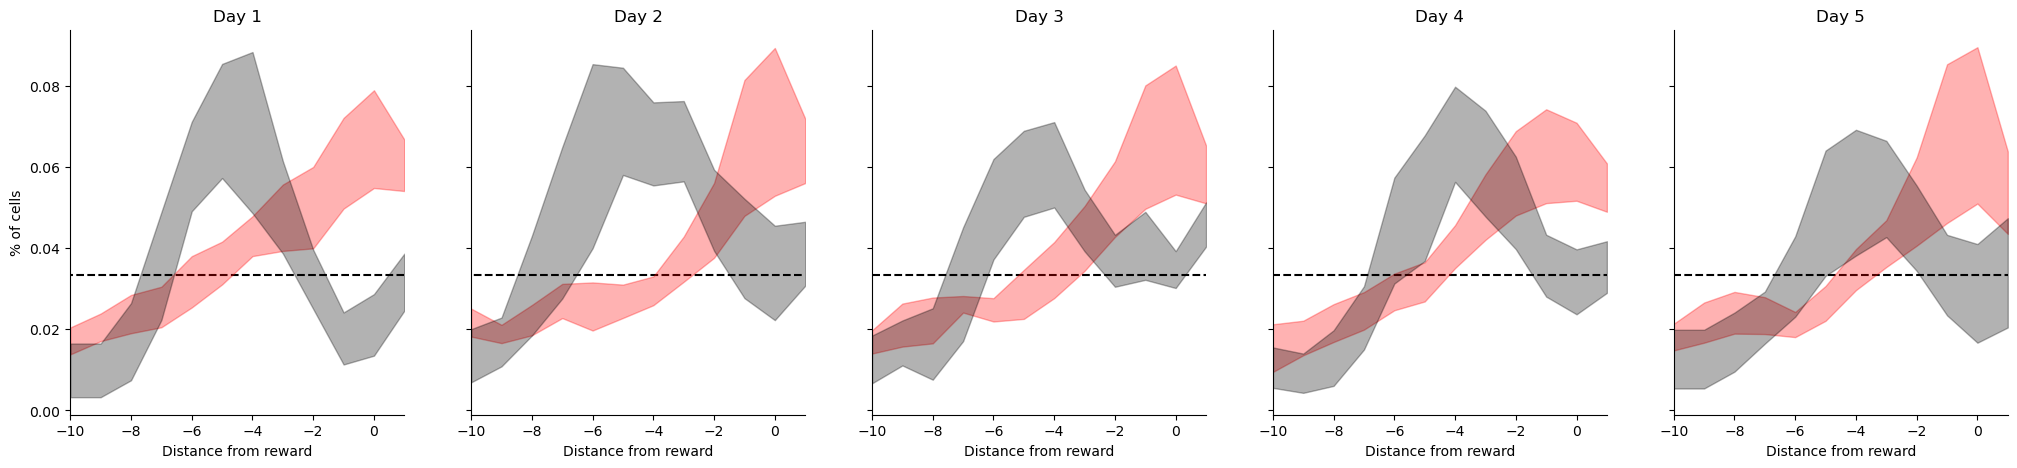

In [93]:
fig,ax = fam_pc_fracs.perireward_hist()
# fig.savefig(os.path.join(figdir,'fam_placecell_frac_perireward.pdf'),format='pdf')

In [83]:
nov_pc_fracs = stx.reward_overrep.PeriRewardPlaceCellFrac(fam=False)

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'sc

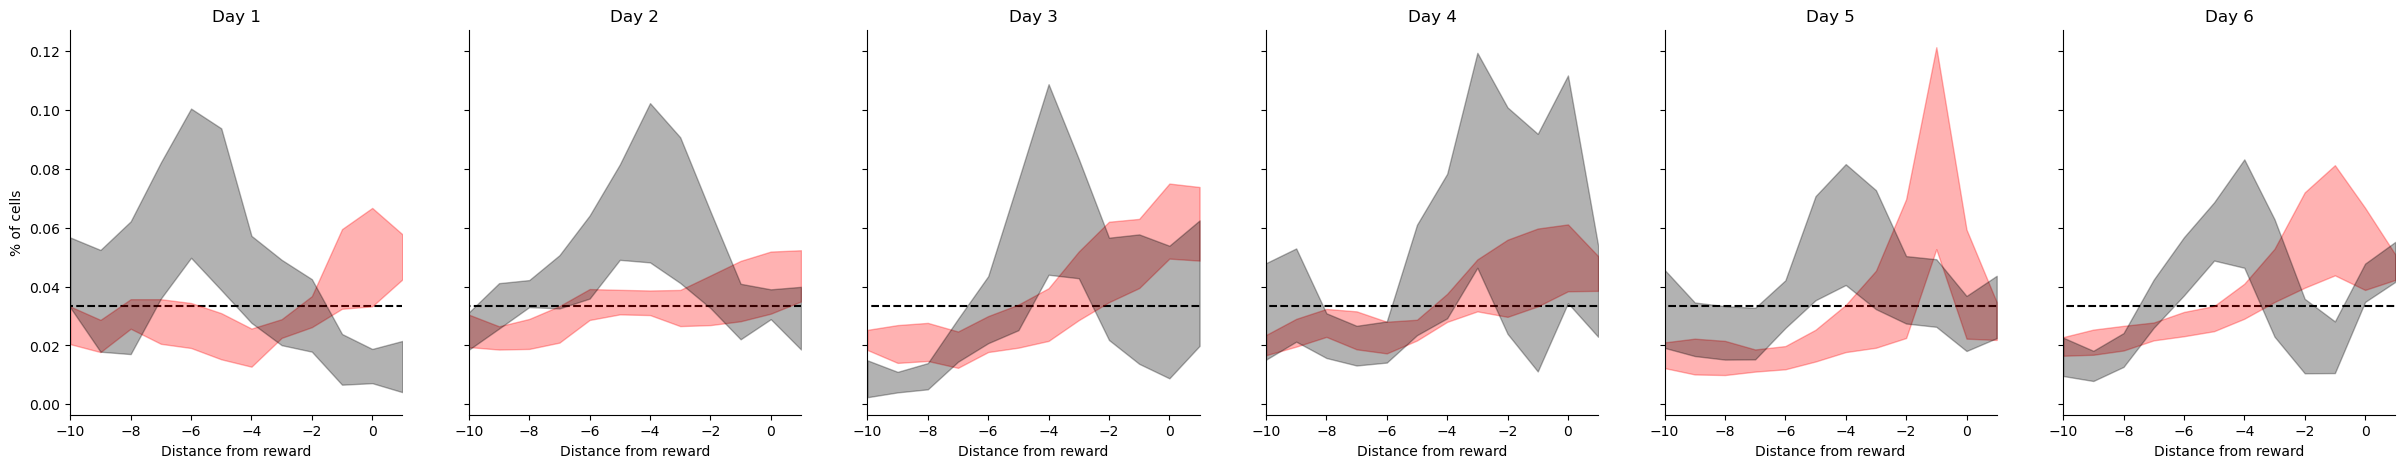

In [84]:
fig,ax = nov_pc_fracs.perireward_hist()
# fig.savefig(os.path.join(figdir,"nov_placecell_frac_perireward.pdf"),format = 'pdf')


In [14]:
def get_smooth_hist(max1, max2,bins = np.arange(0,30)):
    hist, xedges, yedges = np.histogram2d(max1,max2, bins = [bins, bins], density = True)
    hist_sm = sp.ndimage.gaussian_filter(hist, (1,1))
    hist_sm /= hist_sm.ravel().sum()
    return hist_sm


def _get_lr_map(sess):
    
    left_mask = sess.trial_info['LR']==-1
    pc_mask = np.zeros([sess.trial_matrices['spks_norm'].shape[-1],])
    for key in sess.place_cell_info.keys():
        if len(sess.place_cell_info[key]['masks'].shape)>1:
            pc_mask += 1*sess.place_cell_info[key]['masks'].sum(axis=0)
        else:
            pc_mask += 1*sess.place_cell_info[key]['masks']
    pc_mask = pc_mask>0
    
    return np.nanmean(sess.trial_matrices['spks_norm'][left_mask,1:-1,:],axis=0)[:,pc_mask], np.nanmean(sess.trial_matrices['spks_norm'][~left_mask,1:-1,:],axis=0)[:,pc_mask]
  
def get_lr_maps(mice):
    left_mats, right_mats = {}, {}
    for mouse in mice:
        left_mats[mouse]=[]
        right_mats[mouse]=[]
        for day in range(6):
            _left_mat, _right_mat = _get_lr_map(u.load_single_day(mouse,day))
            left_mats[mouse].append(_left_mat)
            right_mats[mouse].append(_right_mat)
    return left_mats, right_mats


    

In [15]:
ctrl_left_mats, ctrl_right_mats = get_lr_maps(ctrl_mice)
ko_left_mats, ko_right_mats = get_lr_maps(ko_mice)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'ses

In [16]:
sess = u.load_single_day(ctrl_mice[0],0)


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


In [17]:
print(rz_early,rz_late)

(array([20]), array([22])) (array([27]), 29)


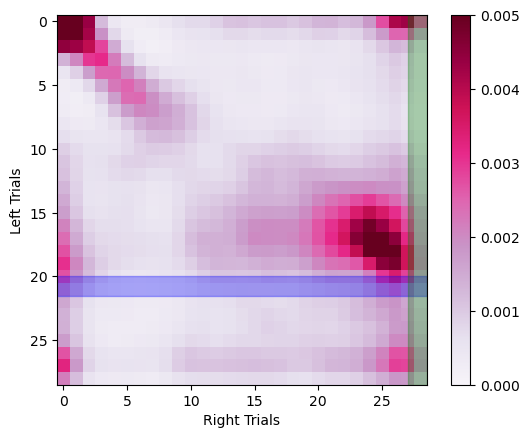

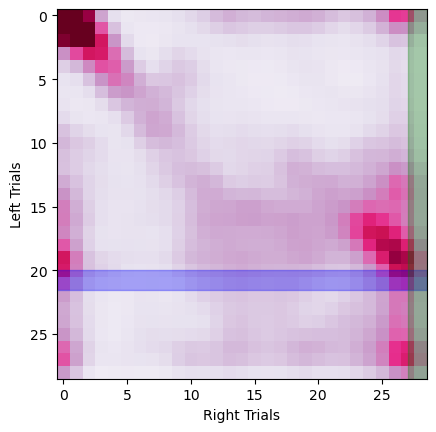

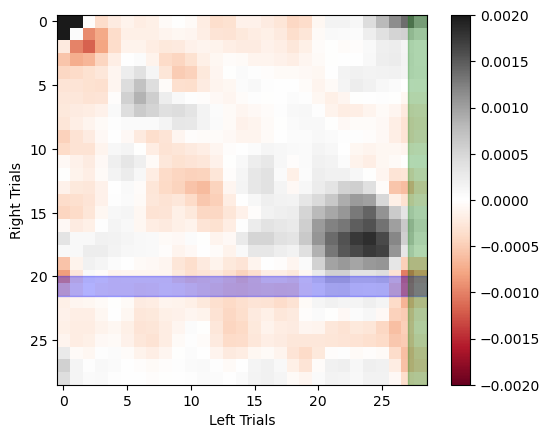

In [18]:
day = 5

ctrl_hist_sm = 0
for mouse in ctrl_mice:
    ctrl_hist_sm += get_smooth_hist(np.argmax(ctrl_left_mats[mouse][day],axis=0), np.argmax(ctrl_right_mats[mouse][day],axis=0))
ctrl_hist_sm /= len(ctrl_mice)
ctrl_hist_sm /= ctrl_hist_sm.ravel().sum()

fig,ax = plt.subplots()
h = ax.imshow(ctrl_hist_sm,vmin=0,vmax=.005, cmap = 'PuRd')
ax.set_ylabel("Left Trials")
ax.set_xlabel("Right Trials")
ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
plt.colorbar(h,ax = ax)
# fig.savefig(os.path.join(figdir,"ctrl_lr_remap_hist_day%d.pdf" % day),format='pdf')

ko_hist_sm = 0
for mouse in ko_mice:
    ko_hist_sm += get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0))
ko_hist_sm /= len(ko_mice)
ko_hist_sm /= ko_hist_sm.ravel().sum()

fig,ax = plt.subplots()
ax.imshow(ko_hist_sm,vmin=0,vmax=.005, cmap = 'PuRd')
ax.set_ylabel("Left Trials")
ax.set_xlabel("Right Trials")
ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
# fig.savefig(os.path.join(figdir,"ko_lr_remap_hist_day%d.pdf" % day),format='pdf')

fig,ax = plt.subplots()
h = ax.imshow(ctrl_hist_sm-ko_hist_sm,cmap='RdGy', vmin= -.002, vmax = .002)
ax.set_xlabel("Left Trials")
ax.set_ylabel("Right Trials")
ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
plt.colorbar(h,ax = ax)
# fig.savefig(os.path.join(figdir,"ko_v_ctrl_lr_remap_hist_day%d.pdf" % day),format='pdf')

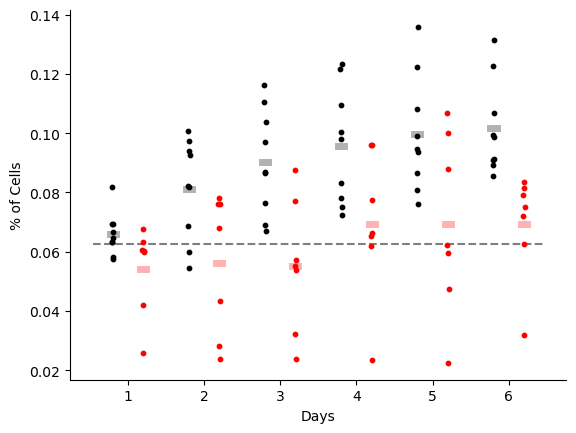

In [19]:
fig,ax = plt.subplots()

ctrl_reward_cells = np.zeros([6,len(ctrl_mice)])
ko_reward_cells = np.zeros([6,len(ko_mice)])

df = pd.DataFrame({'mouse':[],
                    'ko':[],
                    'day':[], 
                    'frac': [], 
                    })

for day in range(6):
    for m, mouse in enumerate(ctrl_mice):
        _hist = get_smooth_hist(np.argmax(ctrl_left_mats[mouse][day],axis=0), np.argmax(ctrl_right_mats[mouse][day],axis=0))
        frac = _hist[rz_early[0][0]-5:rz_early[0][0],rz_late[0][0]-5:rz_late[0][0]].sum(axis=-1).sum(axis=-1)
        ctrl_reward_cells[day,m] = frac
        df = pd.concat((df, pd.DataFrame({'mouse': m,
                        'ko': 0,
                        'day': day,
                        'frac': frac}, index=[len(df)])), ignore_index=True)
        
        
    for m, mouse in enumerate(ko_mice):
        _hist = get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0))
        ko_reward_cells[day,m] = _hist[rz_early[0][0]-5:rz_early[0][0],rz_late[0][0]-5:rz_late[0][0]].sum(axis=-1).sum(axis=-1)
        df = pd.concat((df, pd.DataFrame({'mouse': m+len(ctrl_mice),
                        'ko': 1,
                        'day': day,
                        'frac': frac}, index=[len(df)])), ignore_index=True)
    
for day in range(6):
    ax.scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), ctrl_reward_cells[day,:] , color = 'black', s=10)
    ax.plot(5*day  -1 + np.array([-0.2,0.2]), ctrl_reward_cells[day,:].mean()*np.ones([2,]), color='black', linewidth = 5, alpha = .3)
    
    ax.scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ko_mice)), ko_reward_cells[day,:] , color = 'red', s=10)
    ax.plot(5*day  +1 + np.array([-0.2,0.2]), ko_reward_cells[day,:].mean()*np.ones([2,]), color='red', linewidth = 5, alpha = .3)
    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("% of Cells")
ax.set_xticks(5*np.arange(6))
ax.set_xticklabels(np.arange(1,7))
ax.plot([-2.3, 27.3], ((5/20)**2)*np.ones((2,)), 'k--', zorder= -1, alpha=.5)


# fig.savefig(os.path.join(figdir,"reward_cell_summary.pdf"))
# ko_hist_sm = []
# for mouse in ko_mice:
#     ko_hist_sm.append(get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0)))

# ko_hist_sm = np.array(ko_hist_sm)
# ko_reward_cells = ko_hist_sm[:,rz_early[0][0]-5:rz_early[0][0]-1,rz_late[0][0]-5:rz_late[0][0]-1].sum(axis=-1).sum(axis=-1)

In [20]:
16/(30*30)

0.017777777777777778

In [21]:
res = pg.mixed_anova(data = df, dv= 'frac', between = 'ko', within = 'day', subject = 'mouse')
print(res)

posthoc = pg.pairwise_ttests(data = df, dv= 'frac', between = 'ko', within = 'day', subject = 'mouse', padjust='holm', parametric=True)
print(posthoc)

        Source        SS  DF1  DF2        MS          F         p-unc  \
0           ko  0.009659    1   14  0.009659  21.122244  4.156992e-04   
1          day  0.028052    5   70  0.005610  57.022507  2.467923e-23   
2  Interaction  0.003177    5   70  0.000635   6.458474  5.453582e-05   

        np2       eps  
0  0.601392       NaN  
1  0.802879  0.433039  
2  0.315687       NaN  
    Contrast  day    A    B Paired  Parametric          T   dof alternative  \
0        day    -  0.0  1.0   True        True  -6.532290  15.0   two-sided   
1        day    -  0.0  2.0   True        True  -9.304382  15.0   two-sided   
2        day    -  0.0  3.0   True        True  -9.375215  15.0   two-sided   
3        day    -  0.0  4.0   True        True  -8.818570  15.0   two-sided   
4        day    -  0.0  5.0   True        True -10.384189  15.0   two-sided   
5        day    -  1.0  2.0   True        True  -5.246995  15.0   two-sided   
6        day    -  1.0  3.0   True        True  -6.341935 

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.product(eig) / (eig.sum() / d) ** d
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the 

(6, 9) (6, 7)
3.3343135813572675 0.0008551019694724832


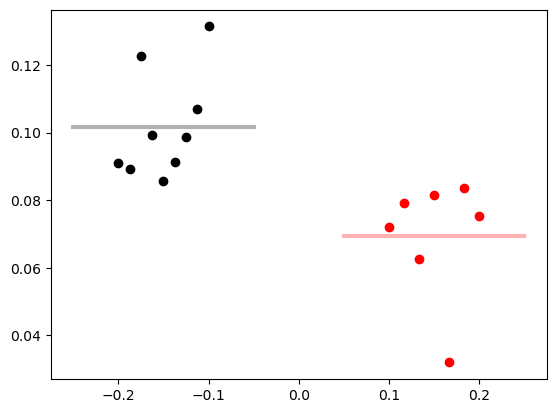

In [22]:
print(ctrl_reward_cells.shape, ko_reward_cells.shape)
t,p = sp.stats.ranksums(ctrl_reward_cells[-1,:], ko_reward_cells[-1,:])
print(t,p)

fig,ax = plt.subplots()
ax.scatter(np.linspace(-.2,-.1,num=len(ctrl_mice)), ctrl_reward_cells[-1,:], color= 'black')
ax.plot(np.array([-.25,-.05]), ctrl_reward_cells[-1,:].mean()*np.ones([2,]),color='black', alpha=.3,linewidth=3)
ax.scatter(np.linspace(.1,.2,num=len(ko_mice)), ko_reward_cells[-1,:], color= 'red')
ax.plot(np.array([.05,.25]), ko_reward_cells[-1,:].mean()*np.ones([2,]),color='red', alpha=.3,linewidth=3)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 's

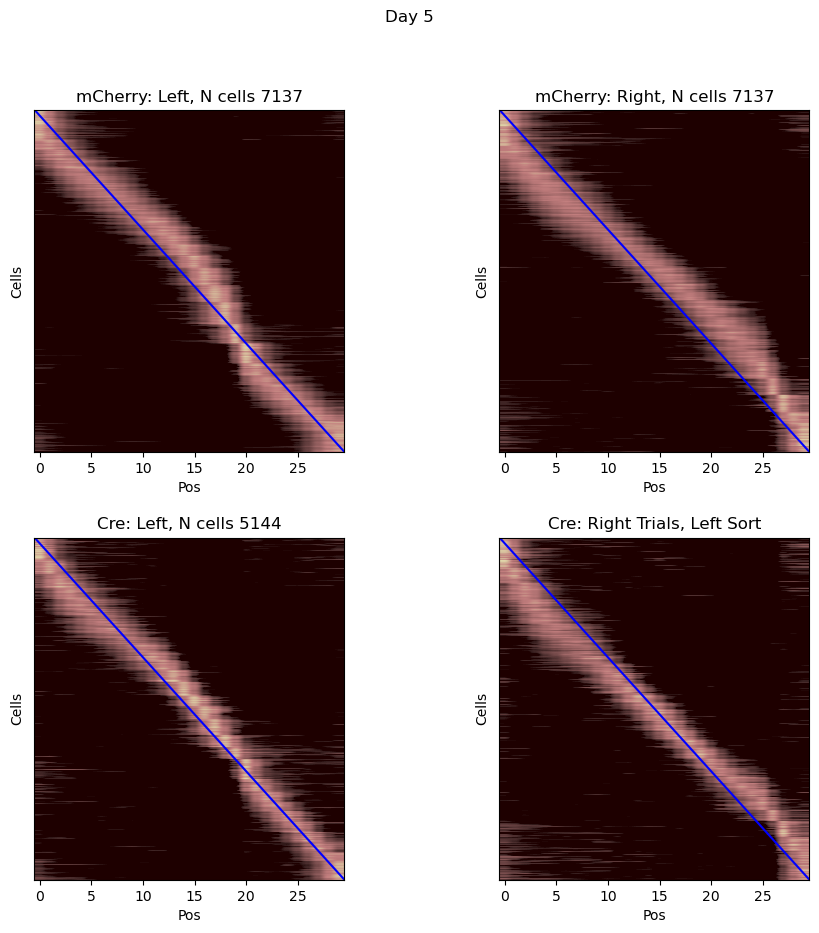

In [26]:
for day in range(5,6):
    fig,ax = stx.reward_overrep.plot_leftright_crossval_placecells_withinday(day, ts_key = 'spks', vmin = 0, vmax=6)
    fig.savefig(os.path.join(figdir,"population_placecells_day%d.pdf" % day), format='pdf')